In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast

cc_codes = ["uk", "de", "pl", "es", "ru", "en"]
filename_pattern_train = "data/multilingual_train/train_{}.csv".format("_".join(cc_codes))
filename_pattern_test = "data/multilingual_train/test_{}.csv".format("_".join(cc_codes))

train_df = pd.read_csv(filename_pattern_train)
test_df = pd.read_csv(filename_pattern_test)

# filterring only texts train part. 
train_df = train_df[train_df["is_text_train"] == 1]

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Building dataset for changes model: 
- Take only those revisions that have one change (avoid noise from multiple changes)
- take only texts that correspond to the text split
- balance dataset

As an input takes the pair of texts

In [34]:
text_changes = []
target = []
revisions = []
lang = []

target_column = "revision_is_identity_reverted"

for rev, text, lable, lang_ in tqdm(zip(train_df.revision_id, train_df.texts_change, train_df[target_column], train_df["wiki_db"])):
    texts_to_add = ast.literal_eval(text).get("Text", [])
    if len(texts_to_add) != 1:
        continue
    for texts in texts_to_add:
        if texts[0] != texts[1]:
            text_changes += [texts]
            target += [lable]
            revisions += [rev]
            lang += [lang_]

train_2 = pd.DataFrame(text_changes, columns = ["sentence1", "sentence2"])
train_2.dropna(inplace=True)
train_2.sentence1 = train_2.sentence1.astype(str)
train_2.sentence2 = train_2.sentence2.astype(str)

train_2["label"] = target
train_2["revision_id"] = revisions
train_2["lang"] = lang

train_2 = train_2[~train_2.sentence1.isin(['N/A', 'NA', "n/a", "na", "None", "nan", "N/a"])]
train_2 = train_2[~train_2.sentence2.isin(['N/A', 'NA', "n/a", "na", "None", "nan", "N/a"])]

911068it [00:18, 49147.80it/s]


In [35]:
train_2.label.mean()

0.4540843480127378

In [36]:
# building balanced dataset
part_1 = train_2[train_2.label == 1]
part_2 = train_2[train_2.label == 0].sample(len(part_1), random_state=42)
balanced = pd.concat([part_1, part_2]).sample(len(part_1)+len(part_2), random_state=42)
balanced.to_csv("data/multilingual_train/text_changes_train_balanced.csv", index=False)

In [37]:
balanced.label.mean()

0.5

In [38]:
len(balanced.label)

308860

In [39]:
balanced.lang.value_counts()

enwiki    100601
dewiki     67675
ruwiki     52061
eswiki     50991
plwiki     24223
ukwiki     13309
Name: lang, dtype: int64

## Modeling attemp: 

In [40]:
from datasets import load_dataset, load_metric, Dataset, ClassLabel
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [41]:
training_dataset = Dataset.from_csv("data/multilingual_train/text_changes_train_balanced.csv")
feat_class = ClassLabel(num_classes=2, names=["not_reverted", "reverted"])
training_dataset = training_dataset.cast_column("label", feat_class)

training_dataset = training_dataset.train_test_split(test_size=0.1, stratify_by_column="label", shuffle=True, seed=42)

Using custom data configuration default-0495e7d43830749f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/trokhymovych/.cache/huggingface/datasets/csv/default-0495e7d43830749f/0.0.0. Subsequent calls will reuse this data.


Casting the dataset:   0%|          | 0/31 [00:00<?, ?ba/s]

In [42]:
training_dataset['train'][0]

{'sentence1': 'No studies have proven any of these claims, nor has the Food and Drug Administration (FDA) approved the recipe',
 'sentence2': 'Numerous studies have proven any of these claims, nor has the Food and Drug Administration (FDA) approved the recipe',
 'label': 1,
 'revision_id': 1080158353,
 'lang': 'enwiki'}

In [46]:
training_dataset['train'].to_pandas().isna().mean()

sentence1      0.0
sentence2      0.0
label          0.0
revision_id    0.0
lang           0.0
dtype: float64

In [44]:
tmp = training_dataset['train'].to_pandas()
tmp[tmp.sentence2.isna()]

,sentence1,sentence2,label,revision_id,lang


In [45]:
# tokenization:
model_checkpoint = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

sentence1_key = "sentence1"
sentence2_key = "sentence2"

def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True, max_length=512)

encoded_dataset = training_dataset.map(preprocess_function, batched=True)

  0%|          | 0/278 [00:00<?, ?ba/s]

  0%|          | 0/31 [00:00<?, ?ba/s]

In [47]:
num_labels = 2
metric_name = "accuracy"
model_name = model_checkpoint.split("/")[-1]
batch_size = 8

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

args = TrainingArguments(
    f"changes_{model_name}-finetuned-multi_balanced",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

metric = load_metric("glue", "mrpc")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [48]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: revision_id, lang, sentence2, sentence1. If revision_id, lang, sentence2, sentence1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 277974
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 173735


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.562900,0.556735,0.714790,0.676128
2,0.508100,0.574525,0.730169,0.722865
3,0.432000,0.641158,0.727579,0.729731
4,0.364800,0.834820,0.731302,0.727392
5,0.317600,1.126580,0.724924,0.732224


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: revision_id, lang, sentence2, sentence1. If revision_id, lang, sentence2, sentence1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30886
  Batch size = 8
Saving model checkpoint to insert_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-34747
Configuration saved in insert_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-34747/config.json
Model weights saved in insert_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-34747/pytorch_model.bin
tokenizer config file saved in insert_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-34747/tokenizer_config.json
Special tokens file saved in insert_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-34747/special_tokens_map.json
Th

TrainOutput(global_step=173735, training_loss=0.44841973653343165, metrics={'train_runtime': 40356.1467, 'train_samples_per_second': 34.44, 'train_steps_per_second': 4.305, 'total_flos': 1.0415135809783368e+17, 'train_loss': 0.44841973653343165, 'epoch': 5.0})

In [49]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: revision_id, lang, sentence2, sentence1. If revision_id, lang, sentence2, sentence1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30886
  Batch size = 8


{'eval_loss': 0.8348198533058167,
 'eval_accuracy': 0.7313022081201839,
 'eval_f1': 0.7273921755411753,
 'eval_runtime': 221.8241,
 'eval_samples_per_second': 139.236,
 'eval_steps_per_second': 17.406,
 'epoch': 5.0}

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: revision_id, lang, sentence2, sentence1. If revision_id, lang, sentence2, sentence1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30886
  Batch size = 8


,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,15443.0,-0.704582,1.325125,-2.067000,-1.647868,-1.307445,-0.024474,2.183171
1,15443.0,0.943397,1.472622,-2.034232,-0.611845,1.816553,2.170639,2.185656


<AxesSubplot:title={'center':'prediction_score'}, xlabel='revision_is_identity_reverted'>

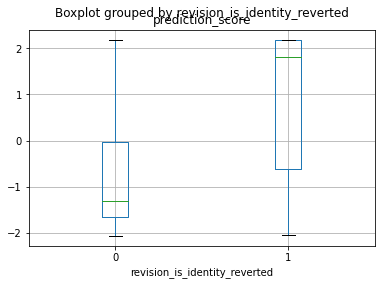

In [50]:
predictions = trainer.predict(encoded_dataset["test"])
test = pd.DataFrame({
                       "prediction_score": predictions.predictions[:, 1],
                       "revision_is_identity_reverted": predictions.label_ids,
                        "lang": encoded_dataset["test"].to_pandas()["lang"]
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


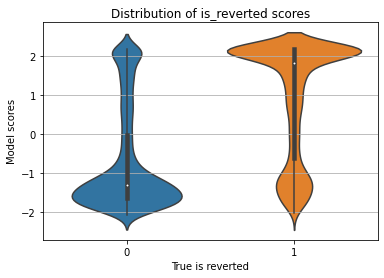

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
# plot violin. 'Scenario' is according to x axis, 
# 'LMP' is y axis, data is your dataframe. ax - is axes instance
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

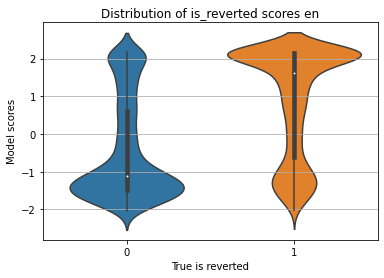

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
# plot violin. 'Scenario' is according to x axis, 
# 'LMP' is y axis, data is your dataframe. ax - is axes instance
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test[test.lang == "enwiki"], ax = axes)
axes.set_title('Distribution of is_reverted scores en')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


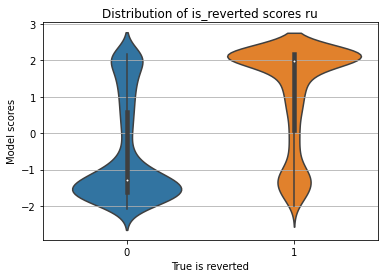

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
# plot violin. 'Scenario' is according to x axis, 
# 'LMP' is y axis, data is your dataframe. ax - is axes instance
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test[test.lang == "ruwiki"], ax = axes)
axes.set_title('Distribution of is_reverted scores ru')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


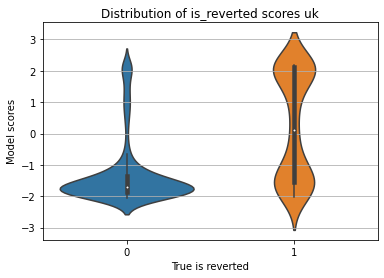

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
# plot violin. 'Scenario' is according to x axis, 
# 'LMP' is y axis, data is your dataframe. ax - is axes instance
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test[test.lang == "ukwiki"], ax = axes)
axes.set_title('Distribution of is_reverted scores uk')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


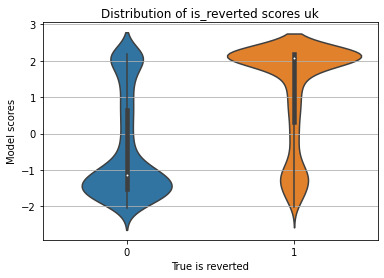

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
# plot violin. 'Scenario' is according to x axis, 
# 'LMP' is y axis, data is your dataframe. ax - is axes instance
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test[test.lang == "eswiki"], ax = axes)
axes.set_title('Distribution of is_reverted scores uk')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()